In [1]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch
import torch.optim as optim
from datasets import ClickDataset
from sklearn.preprocessing import RobustScaler
from utils import create_dtw_pairs
from models import SiameseNetwork, ContrastiveLoss, train_siamese, evaluate_siamese

dataset = ClickDataset('Click_details', transform=RobustScaler())
print("Dataset created", len(dataset))
pairs1, pairs2, labels = create_dtw_pairs(dataset, 1000)
print("Pairs created")
torch.save(dataset, "dataset.pth")
torch.save((pairs1, pairs2, labels), "pairs.pth")

pairs1 = torch.tensor(pairs1, dtype=torch.float32)
pairs2 = torch.tensor(pairs2, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.float32)

model = SiameseNetwork()
criterion = ContrastiveLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-3)

pairs1_train, pairs1_val, pairs2_train, pairs2_val, labels_train, labels_val = train_test_split(pairs1, pairs2, labels, test_size=0.2, random_state=42)

train_dataset = TensorDataset(pairs1_train,
                             pairs2_train,
                             labels_train)

val_dataset = TensorDataset(pairs1_val,
                           pairs2_val,
                           labels_val)


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

train_siamese(model, train_loader, criterion, optimizer, epochs=5)
torch.save(model.state_dict(), "siamese.pth")
evaluate_siamese(model, val_loader)

Processing data...
Dataset created 42980
Created pairs
Class 1:  538  Class 0:  462
Padded the sequences to len: 359
Padded the sequences to len: 780
Pairs created


Epoch 1/5: 100%|██████████| 13/13 [00:15<00:00,  1.22s/it]


Epoch [1/5], Loss: 0.5334


Epoch 2/5: 100%|██████████| 13/13 [00:17<00:00,  1.31s/it]


Epoch [2/5], Loss: 0.5406


Epoch 3/5: 100%|██████████| 13/13 [00:17<00:00,  1.38s/it]


Epoch [3/5], Loss: 0.5404


Epoch 4/5: 100%|██████████| 13/13 [00:15<00:00,  1.22s/it]


Epoch [4/5], Loss: 0.5357


Epoch 5/5: 100%|██████████| 13/13 [00:17<00:00,  1.33s/it]


Epoch [5/5], Loss: 0.5369
Training complete.


Evaluating: 100%|██████████| 4/4 [00:00<00:00,  9.84it/s]

Model Accuracy: 53.50%


In [42]:
import torch
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
import os
from datetime import datetime
from utils import DataProcessor
from collections import defaultdict
from scipy.interpolate import interp1d
from fastdtw import fastdtw
import random
from scipy.spatial.distance import euclidean

DTW_THRESHOLD = 1500


def dtw_distance(seq1, seq2):
    if len(seq1) < 2 or len(seq2) < 2:
        raise ValueError("Sequences must have at least two points")

    distance, _ = fastdtw(seq1.reshape(-1, 1), seq2.reshape(-1, 1), dist=euclidean)
    return distance

def assign_label(seq1, seq2):
    """Assigns label 0 if sequences are similar, else label 1."""
    distance = dtw_distance(seq1, seq2)
    return 0 if distance < DTW_THRESHOLD else 1



class ClickDatasetImproved(Dataset):
    def __init__(self, data_dir, target_length=100, click_filter=None, transform=None):
        print("Processing data...")
        self.target_length = target_length
        self.transform = transform
        self.click_filter = click_filter
        self.data, self.timestamps, self.file_names = self._load_data(data_dir) 

    def get_by_datetime(self, target_datetime, target_file):
        """Retrieve all instances that match the given datetime and file name up to the second."""
        matching_indices = [
            idx for idx, (timestamp, file_name) in enumerate(zip(self.timestamps, self.file_names))
            if timestamp.replace(microsecond=0) == target_datetime.replace(microsecond=0)
               and file_name == target_file
        ]

        if matching_indices:
            return [self.data[idx] for idx in matching_indices], matching_indices 
        return None, [] 

    def _load_data(self, data_dir):
        data_list = []
        timestamps_list = [] 
        file_names_list = [] 

        for file in os.listdir(data_dir):
            df = pd.read_csv(os.path.join(data_dir, file), sep="\t", usecols=['Minute', 'microsec', 'ICI'])

            # Compute absolute timestamps
            df["Datetime"] = datetime(1899, 12, 30) + pd.to_timedelta(df["Minute"], unit="m") + pd.to_timedelta(
                df["microsec"], unit="us")
            df["Clk/s"] = (1 / df["ICI"]) * 1e6  # Convert ICI to clicks per second

            df.drop(columns=['Minute', 'microsec', 'ICI'], inplace=True)
            df['Datetime'] = pd.to_datetime(df['Datetime'])
            df.set_index('Datetime', inplace=True)

            clk_values = df['Clk/s'].values
            is_inf = np.isinf(clk_values)
            split_indices = np.where(is_inf)[0]

            start_idx = 0
            for end_idx in split_indices:
                instance = df.iloc[start_idx:end_idx]

                if len(instance) < 3: 
                    start_idx = end_idx + 1
                    continue

                if self.click_filter and not self.click_filter(instance):
                    start_idx = end_idx + 1
                    continue

                instance = instance.resample("10ms").mean().interpolate()
                if instance.isnull().all().any():
                    start_idx = end_idx + 1
                    continue

                time_values = (instance.index - instance.index[0]).total_seconds().astype(np.float32)
                clk_values = instance['Clk/s'].values.astype(np.float32)

                if len(time_values) < 2 or np.all(time_values == time_values[0]):
                    start_idx = end_idx + 1
                    continue

                new_time_values = np.linspace(0, time_values[-1], self.target_length, dtype=np.float32)
                interp_func = interp1d(time_values, clk_values, kind='linear', fill_value="extrapolate")
                new_clk_values = interp_func(new_time_values)

                data_list.append(new_clk_values) 

                timestamps_list.append(instance.index[0])

                file_words = os.path.basename(file).split(' ')[:2] 
                file_names_list.append('_'.join(file_words))

                start_idx = end_idx + 1

        data_array = np.stack(data_list, axis=0) if data_list else np.array([])

        if self.transform and data_list:
            data_array = self.transform.fit_transform(data_array)

        return data_array, timestamps_list, file_names_list  

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx] 


def filter_low_click_rate(instance):
    return instance['Clk/s'].max() >= 100  


In [38]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch
import torch.optim as optim
# from datasets import ClickDatasetImproved, filter_low_click_rate
from sklearn.preprocessing import RobustScaler
from models import SiameseNetwork, ContrastiveLoss, train_siamese, evaluate_siamese

def create_dtw_pairs(dataset, num_pairs=1000):
    """Generates training pairs with DTW-based similarity labels."""
    pairs_1, pairs_2, labels = [], [], []
    n = len(dataset)

    for _ in range(num_pairs):
        idx1, idx2 = random.sample(range(n), 2)
        seq1, seq2 = dataset[idx1].reshape(-1, 1), dataset[idx2].reshape(-1, 1)

        label = assign_label(seq1, seq2)

        pairs_1.append(seq1)
        pairs_2.append(seq2)
        labels.append(label)
    print("Created pairs")
    print("Class 1: ", sum(labels), " Class 0: ", len(labels) - sum(labels))
    labels = np.array(labels, dtype=np.float32)

    return pairs_1, pairs_2, labels

dataset = ClickDatasetImproved('unlabeled_data', transform=RobustScaler(), click_filter=filter_low_click_rate)
print("Dataset created", len(dataset))
pairs1, pairs2, labels = create_dtw_pairs(dataset, 5000)
print("Pairs created")
torch.save(dataset, "dataset.pth")
torch.save((pairs1, pairs2, labels), "pairs.pth")

pairs1 = torch.tensor(pairs1, dtype=torch.float32)
pairs2 = torch.tensor(pairs2, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.float32)


Processing data...
Dataset created 40905
Created pairs
Class 1:  4631  Class 0:  369
Pairs created


In [50]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch
import torch.optim as optim
from models import SiameseNetwork, ContrastiveLoss
def evaluate_siamese(model, val_loader, criterion=None, threshold=1.0):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for x1, x2, label in val_loader:
            output1, output2 = model(x1, x2)
            if criterion:
                loss = criterion(output1, output2, label)
                total_loss += loss.item()

            distance = torch.norm(output1 - output2, dim=1)
            predictions = (distance < threshold).float()
            correct += (predictions == label).sum().item()
            total += label.size(0)

    avg_loss = total_loss / len(val_loader) if criterion else 0
    acc = correct / total
    print(f"Validation Loss: {avg_loss:.4f}, Validation Accuracy: {acc:.4f} (Threshold: {threshold:.4f})")
    return avg_loss, acc



def train_siamese(model, train_loader, criterion, optimizer, epochs=10, threshold=None):
    model.train()
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    # Optional: dynamic threshold estimation
    if threshold is None:
        print("Calibrating threshold from initial batch...")
        model.eval()
        distances = []
        labels = []
        with torch.no_grad():
            for i, (x1, x2, label) in enumerate(train_loader):
                output1, output2 = model(x1, x2)
                distance = torch.norm(output1 - output2, dim=1)
                distances.append(distance)
                labels.append(label)
                if i > 10:  
                    break
        all_distances = torch.cat(distances)
        all_labels = torch.cat(labels)
        pos_distances = all_distances[all_labels == 0]
        threshold = pos_distances.mean().item()
        print(f"Calibrated threshold: {threshold:.4f}")
        model.train()

    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0
        for x1, x2, label in train_loader:
            optimizer.zero_grad()
            output1, output2 = model(x1, x2)
            loss = criterion(output1, output2, label)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            distance = torch.norm(output1 - output2, dim=1)
            predictions = (distance < threshold).float()
            correct += (predictions == label).sum().item()
            total += label.size(0)

        avg_loss = total_loss / len(train_loader)
        acc = correct / total
        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {avg_loss:.4f}, Train Accuracy: {acc:.4f}")
        history['train_loss'].append(avg_loss)
        history['train_acc'].append(acc)

    return history

model = SiameseNetwork()
criterion = ContrastiveLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-3)

pairs1_train, pairs1_val, pairs2_train, pairs2_val, labels_train, labels_val = train_test_split(pairs1, pairs2, labels, test_size=0.2, random_state=42)

train_dataset = TensorDataset(pairs1_train,
                             pairs2_train,
                             labels_train)

val_dataset = TensorDataset(pairs1_val,
                           pairs2_val,
                           labels_val)


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


Calibrating threshold from initial batch...
Calibrated threshold: 0.6896
Epoch [1/5] - Train Loss: 0.1099, Train Accuracy: 0.1330
Epoch [2/5] - Train Loss: 0.1032, Train Accuracy: 0.1148
Epoch [3/5] - Train Loss: 0.1052, Train Accuracy: 0.1080
Epoch [4/5] - Train Loss: 0.0989, Train Accuracy: 0.1072
Epoch [5/5] - Train Loss: 0.0997, Train Accuracy: 0.1080
Validation Loss: 0.0916, Validation Accuracy: 0.1500 (Threshold: 0.8000)


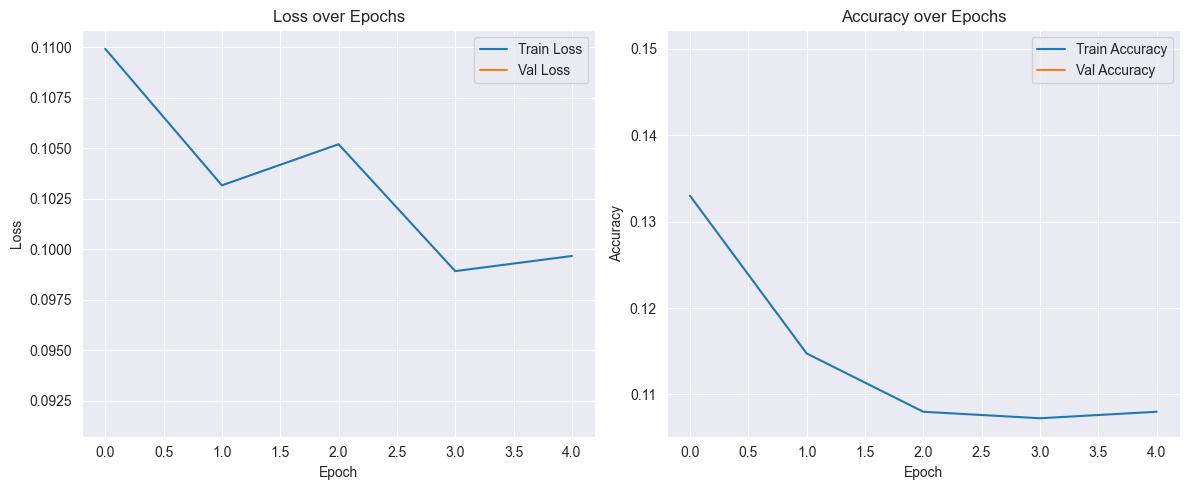

In [56]:
import matplotlib.pyplot as plt

history = train_siamese(model, train_loader, criterion, optimizer, epochs=5)

val_loss, val_acc = evaluate_siamese(model, val_loader, criterion, threshold=0.8)

history['val_loss'].append(val_loss)
history['val_acc'].append(val_acc)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.savefig('training_results.png')
plt.show()


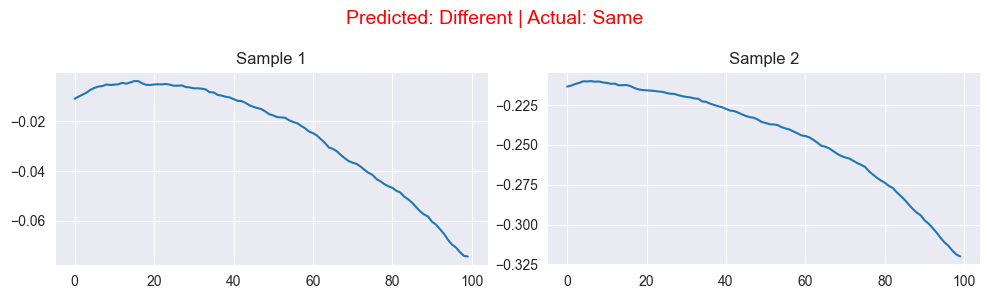

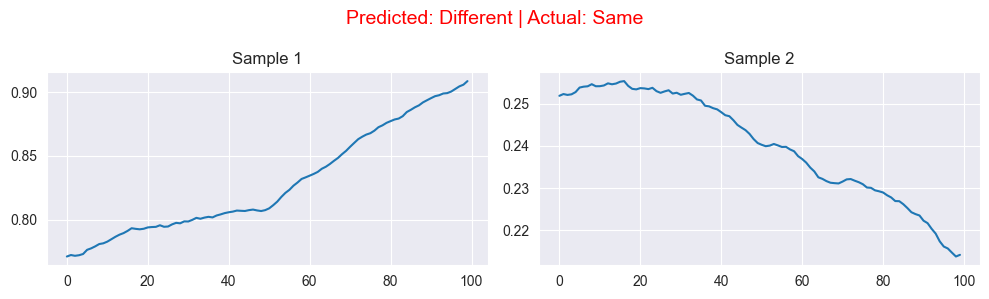

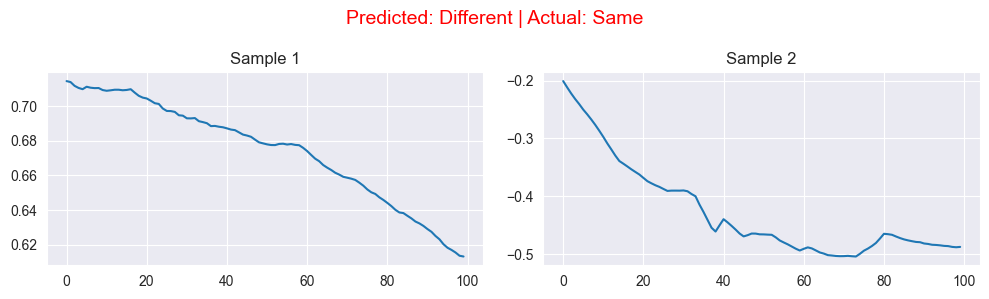

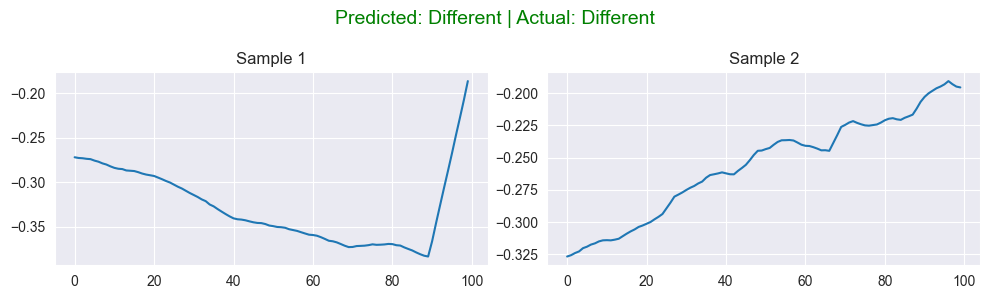

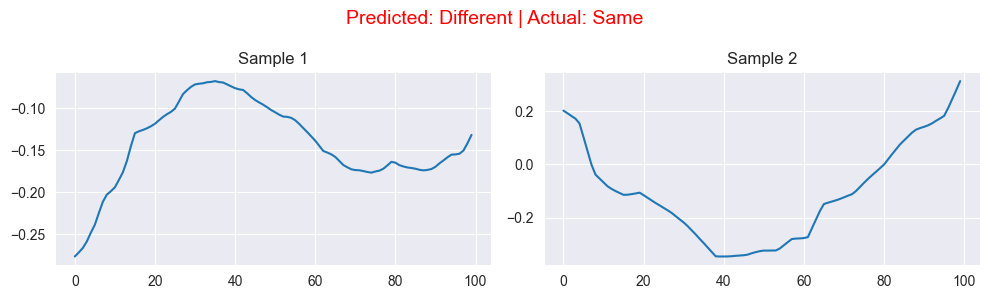

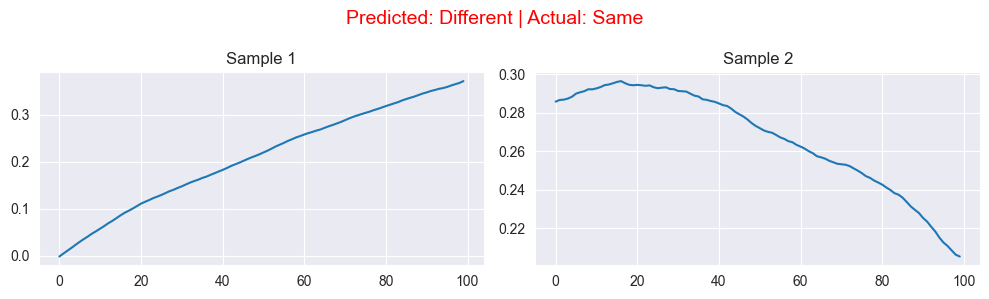

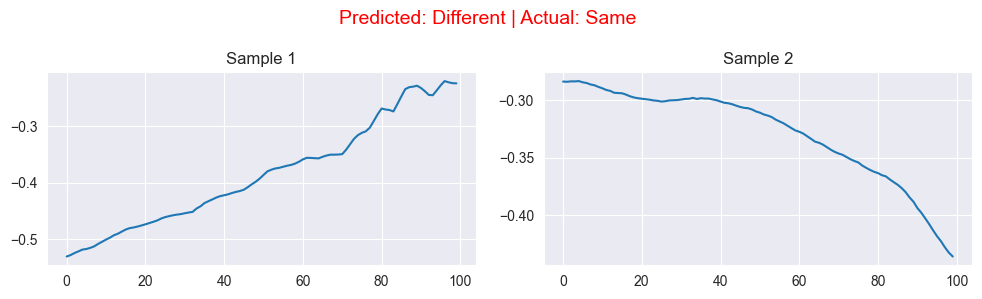

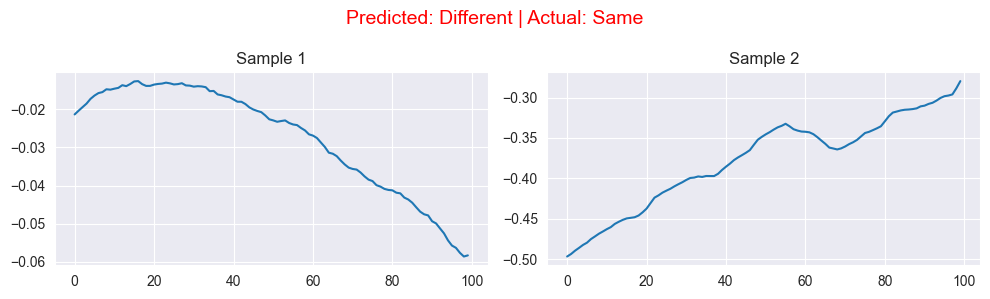

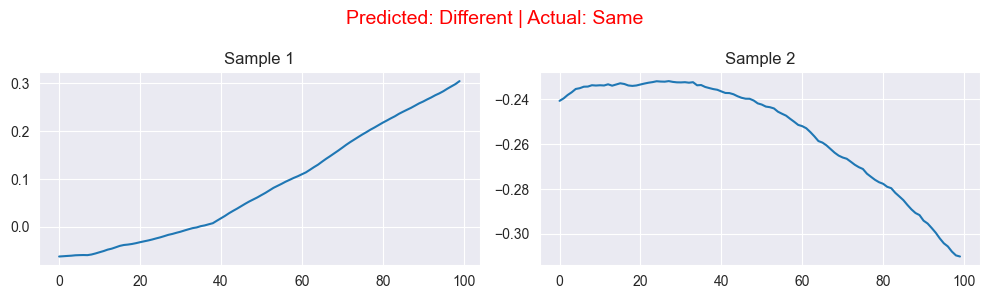

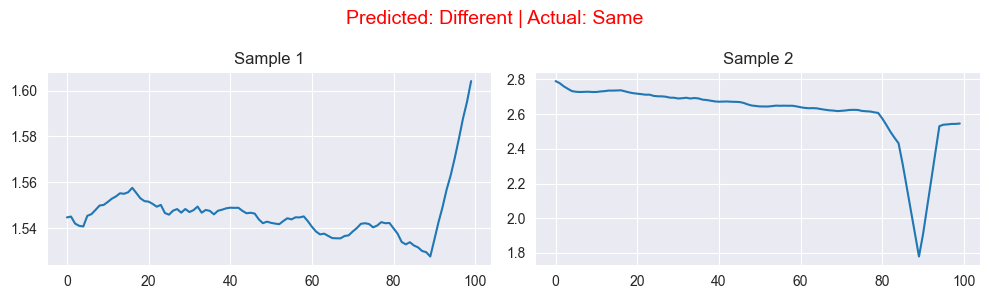

In [57]:
import random
import matplotlib.pyplot as plt

def visualize_predictions(model, val_loader, num_samples=5):
    model.eval()
    samples_shown = 0

    with torch.no_grad():
        for x1, x2, label in val_loader:
            output1, output2 = model(x1, x2)
            distance = torch.norm(output1 - output2, dim=1)
            predictions = (distance < 0.5).float()

            for i in range(len(label)):
                if samples_shown >= num_samples:
                    return

                fig, axs = plt.subplots(1, 2, figsize=(10, 3))
                axs[0].plot(x1[i].numpy())
                axs[0].set_title("Sample 1")
                axs[1].plot(x2[i].numpy())
                axs[1].set_title("Sample 2")

                pred_class = int(predictions[i].item())
                true_class = int(label[i].item())

                plt.suptitle(f"Predicted: {'Same' if pred_class==1 else 'Different'} | Actual: {'Same' if true_class==1 else 'Different'}",
                             fontsize=14, color="green" if pred_class == true_class else "red")
                plt.tight_layout()
                plt.show()

                samples_shown += 1

# Run it
visualize_predictions(model, val_loader, num_samples=10)
